<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [3]:
import sys
sys.path.append('../../')

import pandas as pd
from importlib import reload
import matplotlib.pyplot as plt
from tslearn.datasets import UCR_UEA_datasets
from sklearn import svm
import signature_features
from signature_features import *
import utils
from utils import *
import experiments
from experiments import * 
from sklearn.metrics import accuracy_score
# import gpflow
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF, DotProduct, WhiteKernel

In [28]:
data_name = UCR_UEA_datasets().list_datasets()[2]

In [29]:
data_name

'Beef'

In [30]:
data_loader = UCR_UEA_datasets()
X_train, y_train, X_test, y_test = data_loader.load_dataset(data_name)

In [31]:
print(X_train.shape, X_test.shape)

(30, 470, 1) (30, 470, 1)


In [32]:
pd.DataFrame.from_dict(UCR_UEA_datasets().baseline_accuracy(list_datasets=data_name)).T

,ACF,BN,BOSS,BoP,C45,CID_DTW,DDTW_R1_1NN,DDTW_Rn_1NN,DD_DTW,DTD_C,...,RotF,SAXVSM,ST,SVML,SVMQ,TSBF,TSF,TWE_1NN,WDDTW_1NN,WDTW_1NN
Beef,0.733333,0.6,0.8,0.6,0.533333,0.633333,0.666667,0.7,0.666667,0.666667,...,0.866667,0.433333,0.9,0.9,0.933333,0.566667,0.766667,0.6,0.7,0.7


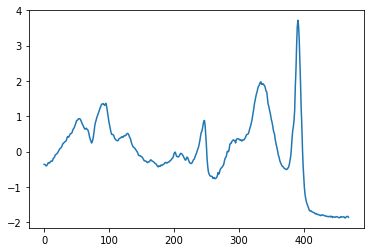

In [33]:
plt.plot(X_train[0])
plt.show()

In [39]:
X_aug_train =  np.concatenate([np.concatenate(np.array_split(e[None,:,:], 5,axis=1))[None,:,:,:] for e in X_train])
X_aug_test =  np.concatenate([np.concatenate(np.array_split(e[None,:,:], 5,axis=1))[None,:,:,:] for e in X_test])

X_aug_train = utils.add_dimension(X_aug_train,add_time=True,lead_lag=None)
X_aug_test = utils.add_dimension(X_aug_test,add_time=True,lead_lag=None)

# X_aug_train = utils.add_dimension(X_aug_train,add_time=False,lead_lag=0)
# X_aug_test = utils.add_dimension(X_aug_test,add_time=False,lead_lag=0)

print(X_aug_train.shape)

C = len(np.unique(y_train))
print('number of classes:', C)

(30, 5, 94, 2)
number of classes: 5


**Sig KME**

In [40]:
# reload(experiments)
# reload(signature_features)

sig_level = 5
M = 1
# Compute the expected signature
X_feat_train = signature_features.scaled_expected_sig([e.copy() for e in X_aug_train],sig_level, ilya_rescale=True,M=M)
X_feat_test = signature_features.scaled_expected_sig([e.copy() for e in X_aug_test],sig_level, ilya_rescale=True,M=M)

# scale the features
scaler = StandardScaler()
to_fit = [X_feat_train[i] for i in range(len(X_feat_train))]
scaler.fit(to_fit)
X_feat_train = scaler.transform(X_feat_train)
X_feat_test = scaler.transform(X_feat_test)

In [41]:
# kernel = 10*RBF(1) + WhiteKernel(noise_level=0.01)
# gpc = GaussianProcessClassifier(kernel=kernel,random_state=0).fit(X_feat_train, y_train)
# gpc.score(X_feat_test, y_test)

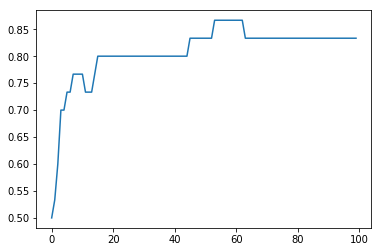

In [50]:
results_penalty = []
for p in np.linspace(0.1, 100, 100):
    clf = svm.SVC(kernel='rbf',gamma='auto',C=p,decision_function_shape='ovr')
    clf = clf.fit(X_feat_train,y_train)
    results_penalty.append(clf.score(X_feat_test, y_test))
plt.plot(results_penalty)

In [43]:
max(results_penalty)

0.8333333333333334

**Pathwise E-Sig**

In [332]:
# specs for pathwise expected sig
sig_level1 = 2

# specs for signature
sig_level2 = 4

M = 3

# pathwise expected sig  
X_feat_train = signature_features.scaled_pathwise_expected_iisignature([e.copy() for e in X_aug_train],
                                                                       sig_level1, ilya_rescale=True,M=M)
X_feat_train = iisignature.sig(X_feat_train,sig_level2)

X_feat_test = signature_features.scaled_pathwise_expected_iisignature([e.copy() for e in X_aug_test],
                                                                      sig_level1,ilya_rescale=True,M=M)
X_feat_test = iisignature.sig(X_feat_test,sig_level2)

scaler = StandardScaler()
to_fit = [X_feat_train[i] for i in range(len(X_feat_train))]
scaler.fit(to_fit)
X_feat_train = scaler.transform(X_feat_train)
X_feat_test = scaler.transform(X_feat_test)

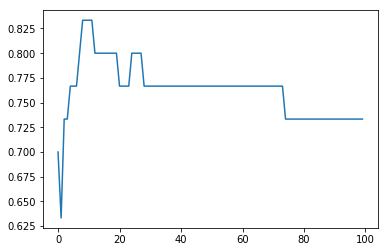

In [333]:
results_penalty = []
for p in np.linspace(0.01, 1, 100):
    clf = svm.SVC(kernel='linear',gamma='auto',C=p,decision_function_shape='ovr')
    clf = clf.fit(X_feat_train,y_train)
    results_penalty.append(clf.score(X_feat_test, y_test))
plt.plot(results_penalty)

In [334]:
max(results_penalty)

0.8333333333333334